In [1]:
# import library
import pandas as pd
import scipy
import scipy.stats
import matplotlib.pyplot as plt
import math

default_figsize = (15,5)

In [2]:
df = pd.read_csv("funding_rounds_processed.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5772 entries, 0 to 5771
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   uuid                      5772 non-null   object 
 1   rank                      5771 non-null   float64
 2   country_code              5755 non-null   object 
 3   region                    5755 non-null   object 
 4   city                      5755 non-null   object 
 5   investment_type           5771 non-null   object 
 6   raised_amount_usd         5107 non-null   float64
 7   post_money_valuation_usd  60 non-null     float64
 8   investor_count            4747 non-null   float64
 9   org_uuid                  5771 non-null   object 
 10  lead_investor_uuids       2632 non-null   object 
dtypes: float64(4), object(7)
memory usage: 496.2+ KB


In [3]:
# drop rows that has null raised_amount_usd
df.dropna(axis=0, how='any', subset=['raised_amount_usd'], inplace = True)

In [4]:
# this function requires a non-null post-money valuation
def percentage_equity(investment: float, pmv: float) -> float:
    '''
    Finds the percentage equity of the investors in the funding round.

    :param float investment: amount raised (in USD)
    :param float pmv: post-money valuation (in USD)
    :return: percentage equity
    :rtype: float
    '''
    return investment / pmv

In [5]:
# df.dropna(axis=0, how='any',inplace = True)
# Note by Stardust: many companies have Nan in post-money valuation, should not dropna

# first consider those with post-money valuation
df_with_pmv = df.dropna(axis=0, how='any')
df_with_pmv['percentage_equity'] = percentage_equity(df_with_pmv['raised_amount_usd'], df_with_pmv['post_money_valuation_usd'])
# df_with_pmv

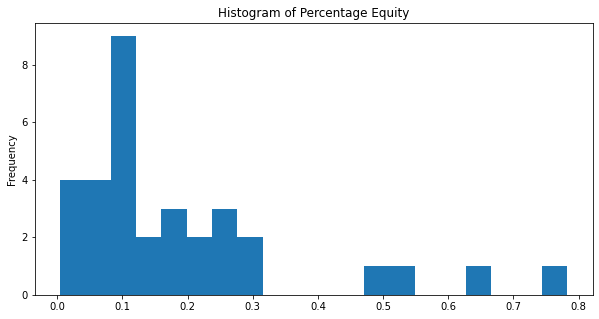

In [6]:
fig, ax = plt.subplots()
df_with_pmv['percentage_equity'].plot.hist(figsize=(10,5), bins=20)
ax.set_title('Histogram of Percentage Equity')
plt.show()

The percentage equity does not give much insight.

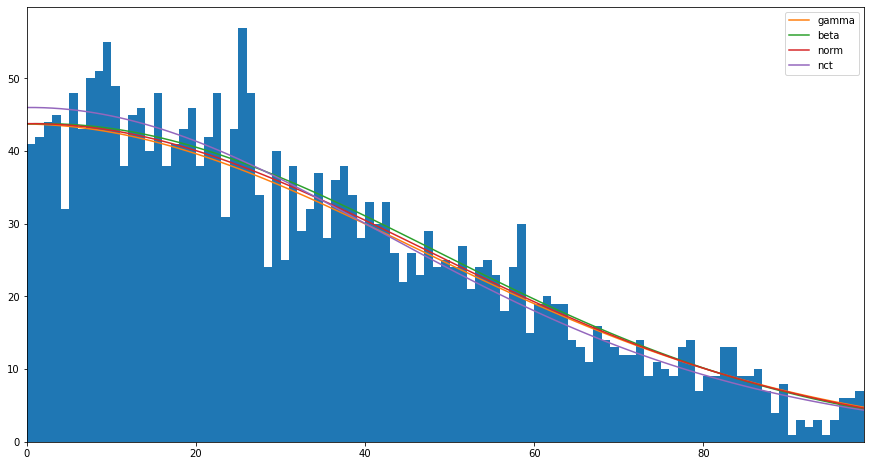

In [15]:
plt.figure(figsize=(15,8))
size = 5107
x = scipy.arange(size)
y = scipy.int_(scipy.round_(scipy.stats.vonmises.rvs(5,size=size)*99))
h = plt.hist(y, bins=range(100))

dist_names = ['gamma', 'beta', 'norm', 'nct']

for dist_name in dist_names:
    dist = getattr(scipy.stats, dist_name)
    param = dist.fit(y)
    pdf_fitted = dist.pdf(x, *param[:-2], loc=param[-2], scale=param[-1]) * size
    plt.plot(pdf_fitted, label=dist_name)
    plt.xlim(0,99)
plt.legend(loc='upper right')
plt.show()

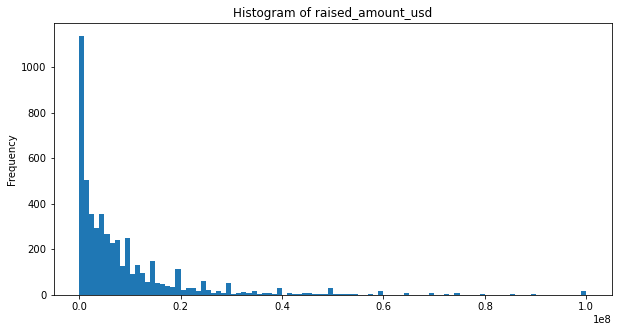

In [16]:
outlier_threshold = 1e8
df_for_hist = df.drop(df[df['raised_amount_usd'] > outlier_threshold].index)
# Stardust: the raw plot was too awful
# very few outliers, but each has dominating amounts of raised amounts
# at least see the overall pattern first

fig, ax = plt.subplots()
df_for_hist['raised_amount_usd'].plot.hist(figsize=(10,5), bins=100)
ax.set_title('Histogram of raised_amount_usd')
plt.show()

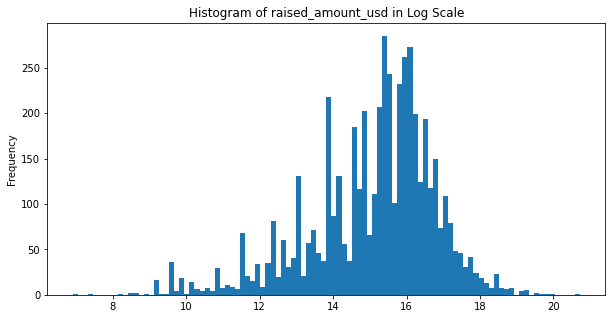

In [9]:
df['raised_amount_usd_log'] = df['raised_amount_usd'].map(math.log)

fig, ax = plt.subplots()
# df_for_hist['raised_amount_usd'].plot.hist(figsize=(10,5))
df['raised_amount_usd_log'].plot.hist(figsize=(10,5), bins=100)
# ax.set_title('Histogram of raised_amount_usd')
ax.set_title('Histogram of raised_amount_usd in Log Scale')
plt.show()

The interpretation is, most companies make ok money, but some make exponentially more.
This affects the way of normalizing the data.
So I used log for now.

In [10]:
df = df.reset_index(drop = True)
df['country_code'].value_counts()

USA    3933
GBR     259
CAN     123
ISR     106
FRA      94
DEU      74
CHN      65
IND      55
ESP      43
NLD      38
SWE      36
CHE      27
BEL      25
IRL      23
DNK      19
AUS      18
SGP      17
ITA      14
JPN      12
FIN      10
KOR       8
NOR       8
BRA       8
AUT       6
EST       6
RUS       6
TWN       5
HKG       5
ARG       5
NZL       5
PHL       4
IDN       4
TUR       4
ZAF       3
CZE       3
ARM       2
HUN       2
LUX       2
AZE       2
CHL       2
PRT       2
COL       2
VEN       2
MEX       1
UKR       1
HRV       1
BGR       1
BGD       1
UZB       1
SVN       1
MYS       1
PAK       1
THA       1
POL       1
Name: country_code, dtype: int64

In [11]:
cleanup_nums = {"USA": 0, "CHN": 1, "SWE": 2, "ISR": 3}
df = df.replace(cleanup_nums)
df['investment_type'].value_counts()

series_a            1562
series_b             987
seed                 716
series_unknown       494
series_c             487
angel                390
series_d             195
debt_financing        79
series_e              62
post_ipo_equity       37
private_equity        32
series_f              27
pre_seed              11
grant                  8
undisclosed            8
post_ipo_debt          5
convertible_note       3
series_g               1
corporate_round        1
secondary_market       1
series_i               1
Name: investment_type, dtype: int64

In [12]:
df['investment_type'].value_counts()
cleanup_nums = {"series_a": 0, "series_b": 1, "series_c": 2, "series_d": 3, "series_e": 4, "private_equity":5, \
               "seed":6, "corporate_fund":7} # also add angel?
df = df.replace(cleanup_nums)
df['region'].value_counts()

California          2112
New York             403
Massachusetts        311
Washington           164
Texas                149
                    ... 
Chandigarh             1
Glasgow City           1
Syddanmark             1
Anhui                  1
Niederosterreich       1
Name: region, Length: 260, dtype: int64

In [13]:
cleanup_nums = {"California": 0, "Massachusetts": 1, "Washington": 2, "Beijing": 3, "Yerushalayim": 4, \
                "North Carolina":5, "New York":6, "Maryland":7, "Stockholms Lan":8, "Texas":9, "Virginia": 10}
df = df.replace(cleanup_nums)
df['city'].value_counts()

San Francisco    548
6                364
Mountain View    138
London           138
San Mateo        131
                ... 
Southbank          1
Mansfield          1
Israelândia        1
Waco               1
0                  1
Name: city, Length: 789, dtype: int64

In [14]:
pd.get_dummies(df, columns=["city"]).head()
# df

,uuid,rank,country_code,region,investment_type,raised_amount_usd,post_money_valuation_usd,investor_count,org_uuid,lead_investor_uuids,...,city_Yerevan,city_Yonkers,city_Yoqne`am `illit,city_York,city_Zaandijk,city_Zagreb,city_Zug,city_Zürich,city_Çan,city_Évry
0,8a945939-18e0-cc9d-27b9-bf33817b2818,348141.0,0,0,angel,500000.0,NaN,4.0,df662812-7f97-0b43-9d3e-12f64f504fbb,3f47be49-2e32-8118-01a0-31685a4d0fd7,...,0,0,0,0,0,0,0,0,0,0
1,d950d7a5-79ff-fb93-ca87-13386b0e2feb,324083.0,0,0,0,12700000.0,98000000.0,4.0,df662812-7f97-0b43-9d3e-12f64f504fbb,b08efc27-da40-505a-6f9d-c9e14247bf36,...,0,0,0,0,0,0,0,0,0,0
2,6fae3958-a001-27c0-fb7e-666266aedd78,202276.0,0,0,1,27500000.0,502500000.0,5.0,df662812-7f97-0b43-9d3e-12f64f504fbb,"e2006571-6b7a-e477-002a-f7014f48a7e3,8d5c7e48-...",...,0,0,0,0,0,0,0,0,0,0
3,bcd5a63d-ed99-6963-0dd2-e36f6582f846,187933.0,0,Colorado,1,10500000.0,NaN,2.0,f53cb4de-236e-0b1b-dee8-7104a8b018f9,NaN,...,0,0,0,0,0,0,0,0,0,0
4,4a56483e-d637-65fa-a2b4-abe6613e5c6b,361467.0,0,0,1,10000000.0,100000000.0,1.0,4111dc8b-c0df-2d24-ed33-30cd137b3098,1787528e-7bd3-a500-ba86-ac55205e7e21,...,0,0,0,0,0,0,0,0,0,0
